In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# mnist dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

from dataset_tools import OwnDataset, make_train_test_val_split, make_small_subset
from plotting import (
    plot_split_stratification,
    show_img, 
    loss_plots, 
    plot_random_images, 
    plot_image_comparison, 
    plot_latent_train, 
    plot_latent)
from collections import defaultdict


cuda = torch.cuda.is_available()
print(cuda)

from sklearn.neighbors import KNeighborsClassifier

FIGURE_DIR = "figures/"

True


In [2]:
tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.view(-1)) # notice that we dont flatten when we are going to use CNN
])
# dataset = OwnDataset(transform=tf)
dataset = OwnDataset(transform=tf, path=r"C:\Users\Otto\Desktop\Fagprojekt_data\labelled_data")
train_subset, test_subset, val_subset = make_train_test_val_split(dataset)

# train_subset = make_small_subset(dataset, 10000)
# test_subset = make_small_subset(dataset, 5000)
# val_subset = make_small_subset(dataset, 5000)

# batch size whole dataset

train_loader = DataLoader(train_subset, batch_size=len(train_subset), shuffle=True)
test_loader = DataLoader(test_subset, batch_size=(len(test_subset)), shuffle=True)
# test_loader = DataLoader(test_subset, batch_size=64, shuffle=True, pin_memory=cuda)
val_loader = DataLoader(val_subset, batch_size=len(val_subset), shuffle=True)

print(len(dataset), len(train_loader), len(test_loader), len(val_loader))

488396 1 1 1


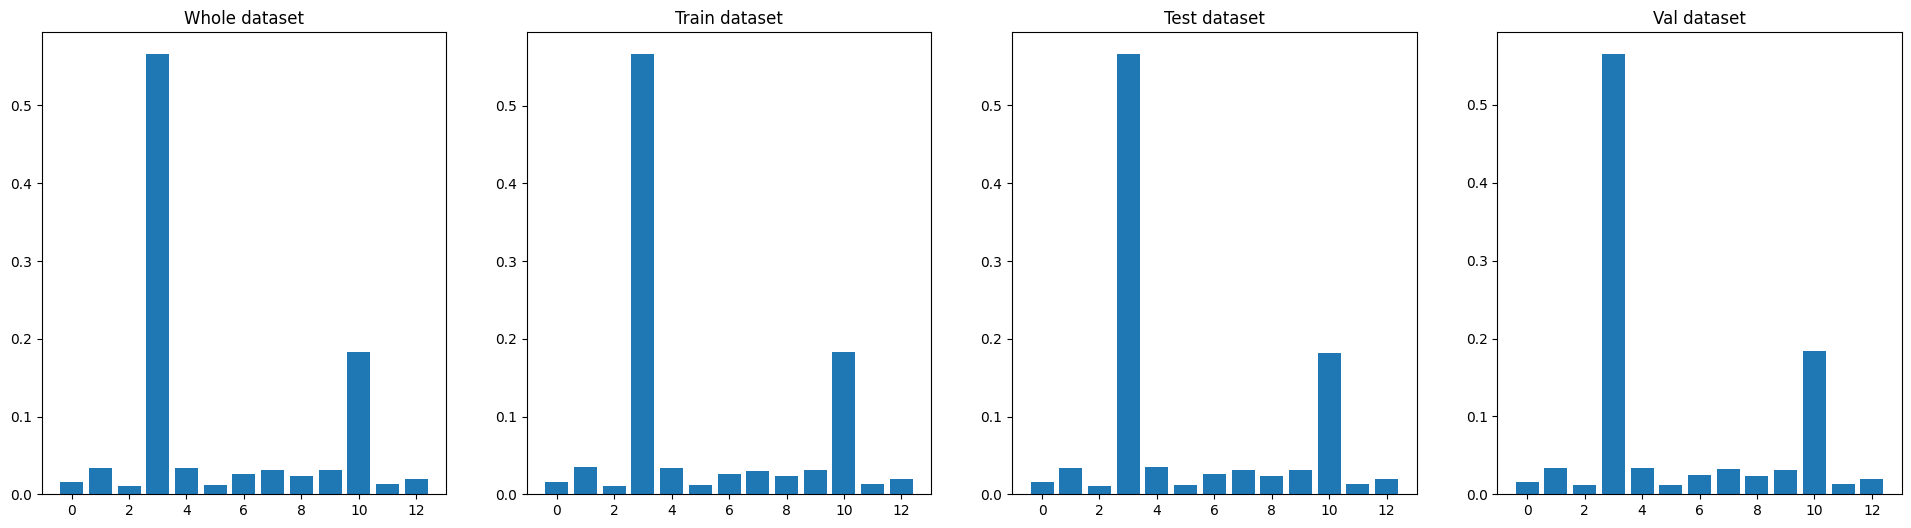

In [3]:
plot_split_stratification(dataset, train_subset, test_subset, val_subset)

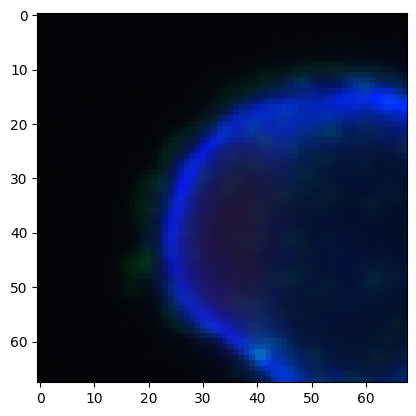

'Actin disruptors'

In [4]:
# get a sample image from the dataset
sample = dataset[612][0]
label = dataset[612][1]

# show the image
show_img(sample.view(3,68,68))

# moa
# data_train.dataset.class_to_idx
dataset.dataset.classes[label]


In [5]:
from models import LatentClassifier, VAE_CELL_CNN, LatentClassifier_2

# load pre-trained model
latent_dim = 32
hidden_dim = 2*latent_dim

# define dirs for the saving of model / data
MODEL_DIR = "trained_models/"
TRAIN_DATA_DIR = "train_data/"

vae = VAE_CELL_CNN(input_dim=(3,68,68), hidden_dim=hidden_dim, latent_dim=latent_dim)
# vae.load_state_dict(torch.load(MODEL_DIR + f"VAE_CELL_CNN_latent{latent_dim}_mean_best_model.pth"))
vae.load_state_dict(torch.load(MODEL_DIR + f"VAE_CELL_CNN_latent{latent_dim}_mean_best_model.pth"))
vae.eval()




VAE_CELL_CNN(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=20736, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=20736, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Unflatten(dim=1, unflattened_size=(256, 9, 9))
    (5): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): LeakyReLU(n

In [6]:
# test forward pass
x, y = next(iter(train_loader))
print(f"x.shape: {x.shape}")

x.shape: torch.Size([312572, 3, 68, 68])


In [7]:
# latent = vae(x)
# run the code above but somehow make it use less memory
with torch.no_grad():
    mu, _ = vae.encode(x)

In [ ]:
# free up memory
# del x
# torch.cuda.empty_cache()

In [8]:
mu.shape

torch.Size([312572, 32])

In [9]:
nbrs = KNeighborsClassifier(n_neighbors=15).fit(mu.detach().numpy(), y.numpy())

In [10]:
x_test, y_test = next(iter(test_loader))
print(f"x.shape: {x.shape}")


x.shape: torch.Size([312572, 3, 68, 68])


In [11]:
with torch.no_grad():
    mu_test, _ = vae.encode(x_test)

In [12]:
pred = nbrs.predict(mu_test.detach().numpy())
mean = np.mean(pred == y_test.numpy())


In [13]:
mean
# 0.6727784602784603

0.674897624897625

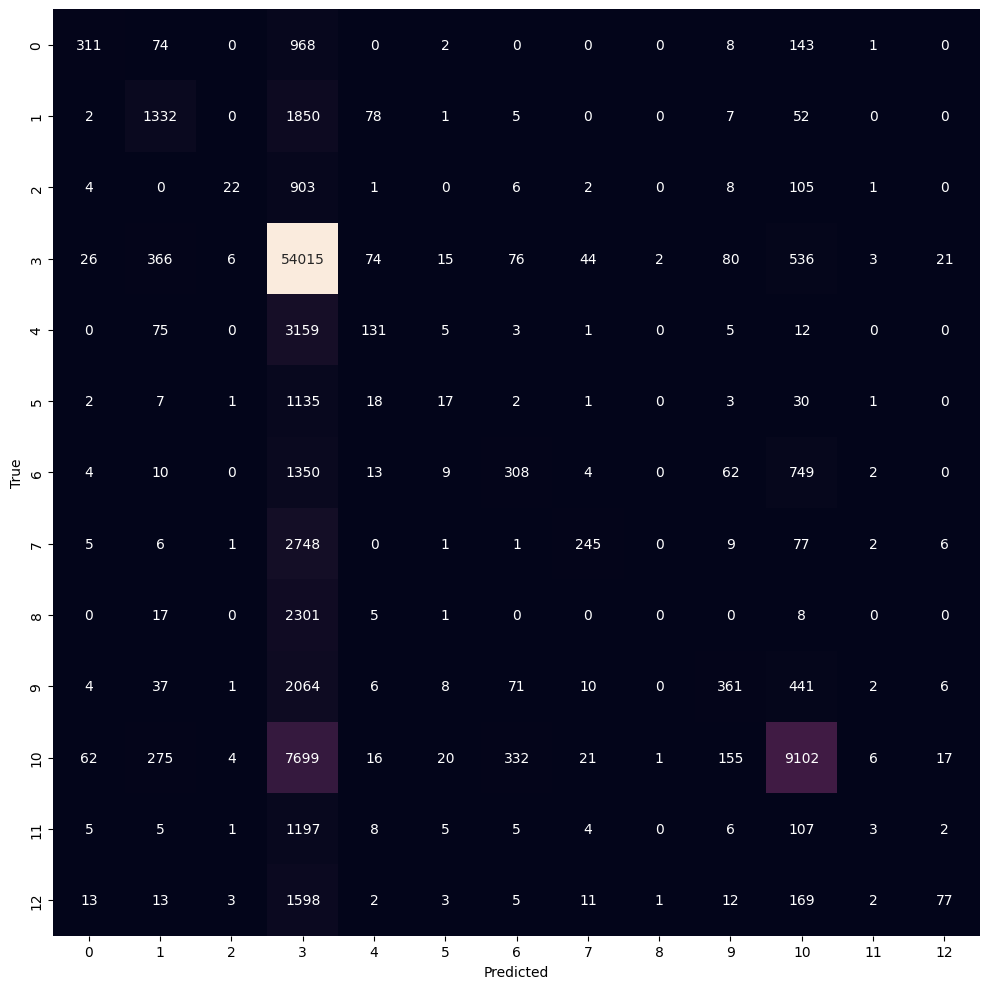

In [14]:
# confusion matrix

confus = confusion_matrix(y_test.numpy(), pred)

# plot the confusion matrix
import seaborn as sns
plt.figure(figsize=(10,10))
# sns.heatmap(confus, annot=True, fmt="d")
# heatmap without colorbar
sns.heatmap(confus, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(FIGURE_DIR + f"KNN_confusion_matrix_latent{latent_dim}")
# plt.show()


In [15]:
# calculate recall and precision
from sklearn.metrics import recall_score, precision_score

recall = recall_score(y_test.numpy(), pred, average="macro")
precision = precision_score(y_test.numpy(), pred, average="macro")

recall, precision

(0.19505475618251225, 0.4786937622630059)

In [16]:
# create a dict accuracy_data for storing the results
accuracy_data = {}
accuracy_data["recall"] = recall
accuracy_data["precision"] = precision
accuracy_data["accuracy"] = mean

In [17]:
# save the accuracy data
import json
with open(TRAIN_DATA_DIR + f"KNN_accuracy_data_latent{latent_dim}.json", "w") as f:
    json.dump(accuracy_data, f)
